In [66]:
pip install ticketpy


In [67]:
import ticketpy
from ticketpy.model import Venue, Event, Attraction, Classification

In [68]:
import requests
import pandas as pd
import time
import math
from pathlib import Path


In [69]:

url = "https://app.ticketmaster.com/discovery/v2/events?apikey=4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs&locale=*&countryCode=ES&classificationName=music"

r = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
print(r.status_code)

# respuesta es un diccionario con 3 claves
respuesta = r.json()

links = respuesta['_links']
print(links)

datos = respuesta['_embedded']

pages = respuesta['page']
print(pages)

datos

df = pd.DataFrame(datos['events']) #para constriur el dataframe con los eventos
len(df)
# if r.status_code == 200:
#     # Imprimir la respuesta en formato JSON
#     #print(response.json())
#     df = pd.DataFrame(r.json()) # Utilizar pd.json_normalize para manejar datos anidados si es necesario

# else:
#     # Manejar el error si la solicitud no fue exitosa
#     print(f"Error: {r.status_code}")
#     print(r.text)  # Puedes imprimir el texto de la respuesta para obtener más detalles del error si es necesario


# df

200
{'first': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=0&size=20'}, 'self': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*'}, 'next': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=1&size=20'}, 'last': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=38&size=20'}}
{'size': 20, 'totalElements': 772, 'totalPages': 39, 'number': 0}


20

In [70]:
pag = 0
url = 'https://app.ticketmaster.com/discovery/v2/events?apikey=4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs&countryCode=ES&classificationName=music&locale=*&page=' + str(pag)
r = requests.get(url)

if r.status_code == 200:
  respuesta = r.json()
  total_pages = respuesta['page']['totalPages']
  print(total_pages)
  df_datos = pd.DataFrame(respuesta['_embedded']['events'])
  pag += 1
  while(pag < total_pages):
    url = 'https://app.ticketmaster.com/discovery/v2/events?apikey=4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs&countryCode=ES&classificationName=music&locale=*&page=' + str(pag)
    r = requests.get(url)
    res = r.json()
    df_datos_mas = pd.DataFrame(res['_embedded']['events'])
    df_datos = pd.concat([df_datos, df_datos_mas], ignore_index=True)
    pag += 1
else:
  print('Error: ' + r.status_code)
  print(r.text)


len(df_datos)

39


772

In [71]:
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             772 non-null    object
 1   type             772 non-null    object
 2   id               772 non-null    object
 3   test             772 non-null    bool  
 4   url              772 non-null    object
 5   locale           772 non-null    object
 6   images           772 non-null    object
 7   sales            772 non-null    object
 8   dates            772 non-null    object
 9   classifications  772 non-null    object
 10  promoter         771 non-null    object
 11  promoters        771 non-null    object
 12  priceRanges      769 non-null    object
 13  seatmap          84 non-null     object
 14  _links           772 non-null    object
 15  _embedded        772 non-null    object
dtypes: bool(1), object(15)
memory usage: 91.3+ KB


In [72]:
print(df_datos['type'].unique())    # la columna type toma únicamente el valor 'event' -> eliminar
df_datos_menos_col = df_datos.drop(columns = ['test', 'url','images',
                                              'promoters', 'type', 'locale',
                                              '_links', 'seatmap'])
#df_datos_menos_col['dates']
df_datos_menos_col.iloc[2]['classifications']

['event']


[{'primary': True,
  'segment': {'id': 'KZFzniwnSyZfZ7v7nn', 'name': 'Film'},
  'genre': {'id': 'KnvZfZ7vAkJ', 'name': 'Music'},
  'subGenre': {'id': 'KZazBEonSMnZfZ7vave', 'name': 'Music'},
  'family': False}]

In [73]:
def obtener_start_datetime(fila):
    if 'access' in fila['dates'] and 'startDateTime' in fila['dates']['access']:
        return fila['dates']['access']['startDateTime']
    else:
        return None  # O un valor predeterminado que desees asignar cuando la clave no está presente

df_datos_menos_col['dates'] = df_datos_menos_col.apply(obtener_start_datetime,axis=1)


In [74]:
def obtener_min_price(fila):
    if 'priceRanges' in fila and isinstance(fila['priceRanges'], list) and fila['priceRanges']:
        return fila['priceRanges'][0]['min']
    else:
        return None

def obtener_max_price(fila):
    if 'priceRanges' in fila and isinstance(fila['priceRanges'], list) and fila['priceRanges']:
        return fila['priceRanges'][0]['max']
    else:
        return None
# Aplicar las funciones a cada fila de la columna 'prices' y asignar los resultados a nuevas columnas 'min_price' y 'max_price'
df_datos_menos_col['min_price'] = df_datos_menos_col.apply(obtener_min_price, axis=1)
df_datos_menos_col['max_price'] = df_datos_menos_col.apply(obtener_max_price, axis=1)


In [75]:
def obtener_start_datetime(fila):
        return fila['sales']['public'].get('startDateTime')

def obtener_end_datetime(fila):
    return fila['sales']['public'].get('endDateTime')


In [76]:
df_datos_menos_col['StartTimeSale'] = df_datos_menos_col.apply(obtener_start_datetime, axis=1)
df_datos_menos_col['EndTimeSale'] = df_datos_menos_col.apply(obtener_end_datetime, axis=1)

In [77]:
def obtener_promotor(fila):
    if 'promoter' in fila and isinstance(fila['promoter'], dict):
        return fila['promoter'].get('name')
    else:
        return None

df_datos_menos_col['Promotor'] = df_datos_menos_col.apply(obtener_promotor, axis=1)


In [78]:
def obtener_genero(fila):
    if isinstance(fila['classifications'], list) and fila['classifications']:
        # Verifica si classifications es una lista no vacía
        for item in fila['classifications']:
            if 'genre' in item and isinstance(item['genre'], dict):
                return item['genre'].get('name')
    return None

def obtener_subgenero(fila):
    if isinstance(fila['classifications'], list) and fila['classifications']:
        for item in fila['classifications']:
            if 'subGenre' in item and isinstance(item['subGenre'], dict):
                return item['subGenre'].get('name')
    return None

df_datos_menos_col['Genero'] = df_datos_menos_col.apply(obtener_genero, axis=1)
df_datos_menos_col['Subgenero'] = df_datos_menos_col.apply(obtener_subgenero, axis=1)



In [79]:
# Calcular la media de los precios mínimos
media_precios_min = df_datos_menos_col['min_price'].mean()

# Calcular la mediana de los precios mínimos
mediana_precios_min = df_datos_menos_col['min_price'].median()

print("Media de los precios mínimos:", media_precios_min)
print("Mediana de los precios mínimos:", mediana_precios_min)


Media de los precios mínimos: 62.83157347204162
Mediana de los precios mínimos: 38.0


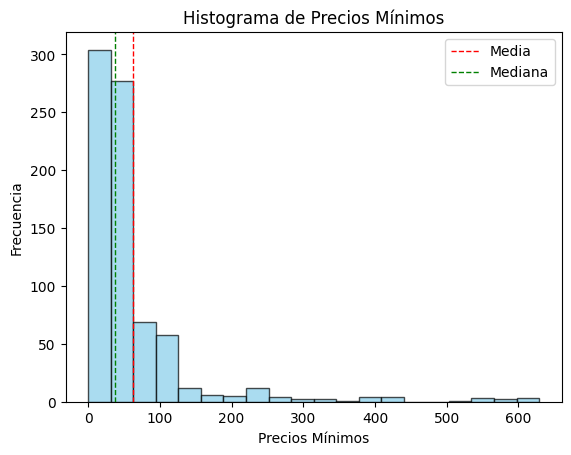

In [80]:
import matplotlib.pyplot as plt

# Crear un histograma de los precios mínimos
plt.hist(df_datos_menos_col['min_price'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Agregar una línea vertical para la media
plt.axvline(media_precios_min, color='red', linestyle='dashed', linewidth=1, label='Media')

# Agregar una línea vertical para la mediana
plt.axvline(mediana_precios_min, color='green', linestyle='dashed', linewidth=1, label='Mediana')

# Etiquetas y título
plt.xlabel('Precios Mínimos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios Mínimos')
plt.legend()

# Mostrar el histograma
plt.show()


In [81]:
# Calcular la media de los precios mínimos
media_precios_max = df_datos_menos_col['max_price'].mean()

# Calcular la mediana de los precios mínimos
mediana_precios_max = df_datos_menos_col['max_price'].median()

print("Media de los precios máximos:", media_precios_max)
print("Mediana de los precios máximos:", mediana_precios_max)

Media de los precios máximos: 193.12106631989593
Mediana de los precios máximos: 60.5


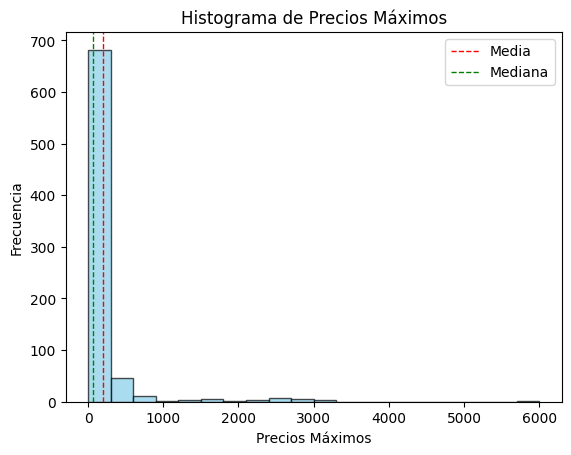

In [82]:
import matplotlib.pyplot as plt

# Crear un histograma de los precios mínimos
plt.hist(df_datos_menos_col['max_price'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Agregar una línea vertical para la media
plt.axvline(media_precios_max, color='red', linestyle='dashed', linewidth=1, label='Media')

# Agregar una línea vertical para la mediana
plt.axvline(mediana_precios_max, color='green', linestyle='dashed', linewidth=1, label='Mediana')

# Etiquetas y título
plt.xlabel('Precios Máximos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios Máximos')
plt.legend()

# Mostrar el histograma
plt.show()

In [85]:
df_datos_menos_col

,name,id,sales,dates,classifications,promoter,priceRanges,_embedded,min_price,max_price,StartTimeSale,EndTimeSale,Promotor,Genero,Subgenero,VenueName,VenueCity,VenueState,VenueCountry
0,Sunsetland Festival,Z698xZ2qZaa_L,{'public': {'startDateTime': '2024-01-25T11:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6285', 'name': 'Taborodri Hostelería S...","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Recinto Ferial La Fica',...",45.0,70.0,2024-01-25T11:00:00Z,2024-06-28T18:00:00Z,Taborodri Hostelería S.L.,Music,Music,Recinto Ferial La Fica,Murcia,Murcia,Spain
1,Servicio de Autobús - BRESH - Grand Opening -...,Z698xZ2qZaa_M,{'public': {'startDateTime': '2024-01-24T14:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'venues': [{'name': 'ServicioBus ConcertMusic...,17.5,27.5,2024-01-24T14:00:00Z,2024-06-28T10:00:00Z,CONCERT TOUR Y EN VIVO AIE,Music,Music,ServicioBus ConcertMusicFestival,Chiclana de la Frontera,Cádiz,Spain
2,BRESH - Grand Opening Concert Music Festival,Z698xZ2qZaa_S,{'public': {'startDateTime': '2024-01-24T14:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Concert Music Festival',...",10.0,10.0,2024-01-24T14:00:00Z,2024-06-28T21:59:00Z,CONCERT TOUR Y EN VIVO AIE,Music,Music,Concert Music Festival,Chiclana de la Frontera,Cádiz,Spain
3,Manolo García - Concert Music Festival,Z698xZ2qZaaC4,{'public': {'startDateTime': '2023-11-30T11:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Concert Music Festival',...",55.0,2100.0,2023-11-30T11:00:00Z,2024-06-29T21:59:00Z,CONCERT TOUR Y EN VIVO AIE,Music,Music,Concert Music Festival,Chiclana de la Frontera,Cádiz,Spain
4,Servicio de Autobús - Manolo García - Concert...,Z698xZ2qZaaC9,{'public': {'startDateTime': '2023-11-30T11:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'venues': [{'name': 'ServicioBus ConcertMusic...,17.5,27.5,2023-11-30T11:00:00Z,2024-06-29T10:00:00Z,CONCERT TOUR Y EN VIVO AIE,Music,Music,ServicioBus ConcertMusicFestival,Chiclana de la Frontera,Cádiz,Spain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,"The Music of El Señor de los Anillos,El Hobbit...",Z698xZ2qZaFWs,{'public': {'startDateTime': '2023-08-09T15:28...,2025-03-02T14:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5813', 'name': 'Star Entertainment GmbH'}","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Palacio Vistalegre', 'ty...",39.0,79.0,2023-08-09T15:28:00Z,2025-03-02T14:00:00Z,Star Entertainment GmbH,Classical,Classical/Vocal,Palacio Vistalegre,Madrid,Madrid,Spain
768,The Magical Music of Harry Potter,Z698xZ2qZaaoh,{'public': {'startDateTime': '2023-12-07T16:17...,2025-03-06T19:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5813', 'name': 'Star Entertainment GmbH'}","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'venues': [{'name': 'Palau de Congressos de T...,36.6,65.7,2023-12-07T16:17:00Z,2025-03-06T19:00:00Z,Star Entertainment GmbH,Classical,Classical/Vocal,Palau de Congressos de Tarragona,Tarragona,Tarragona,Spain
769,Barcelona Bar Showroom,Z698xZ2qZaar2,{'public': {'startDateTime': '2024-02-13T16:26...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6341', 'name': 'BN GRUP 2019 S.L.'}","[{'type': 'standard including fees', 'currency...",{'venues': [{'name': 'Hyatt Regency Barcelona ...,13.7,13.7,2024-02-13T16:26:00Z,2024-03-17T11:00:00Z,BN GRUP 2019 S.L.,Fairs & Festivals,Fairs & Festivals,Hyatt 

In [ ]:
df_datos_menos_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             772 non-null    object 
 1   id               772 non-null    object 
 2   sales            772 non-null    object 
 3   dates            301 non-null    object 
 4   classifications  772 non-null    object 
 5   promoter         771 non-null    object 
 6   priceRanges      769 non-null    object 
 7   _embedded        772 non-null    object 
 8   min_price        769 non-null    float64
 9   max_price        769 non-null    float64
 10  StartTimeSale    772 non-null    object 
 11  EndTimeSale      772 non-null    object 
 12  Promotor         771 non-null    object 
 13  Genero           772 non-null    object 
 14  Subgenero        772 non-null    object 
dtypes: float64(2), object(13)
memory usage: 90.6+ KB


In [ ]:
nicki_nicole = df_datos[df_datos['name'].str.contains('Nicki Nicole')]
nicki_nicole.iloc[0]['dates']
#nicki_nicole['startDateTime'] = nicki_nicole['sales']['public']['startDateTime']
# print(nicki_nicole.iloc[0]['priceRanges'])
# print(nicki_nicole.iloc[1]['priceRanges'])
nicki_nicole.iloc[0]['classifications']
nicki_nicole.iloc[0]['_embedded']
nicki_nicole.iloc[0]['classifications']



[{'primary': True,
  'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
  'genre': {'id': 'KnvZfZ7vAvl', 'name': 'Other'},
  'subGenre': {'id': 'KZazBEonSMnZfZ7vk1I', 'name': 'Other'},
  'family': False}]

In [ ]:
taylor = df_datos[df_datos['name'].str.contains('Taylor Swift')]
#eladio.iloc[0]['sales']['public']['startDateTime']
# print(taylor.iloc[0]['priceRanges'])
# print(taylor.iloc[1]['priceRanges'])
# #print(taylor.iloc[0]['seatmap'])
# print(taylor.iloc[0]['_links'])
# print(taylor.iloc[0]['classifications'])


[{'type': 'standard including fees', 'currency': 'EUR', 'min': 282.0, 'max': 589.0}, {'type': 'standard', 'currency': 'EUR', 'min': 249.0, 'max': 549.0}]
[{'type': 'standard', 'currency': 'EUR', 'min': 65.0, 'max': 200.0}, {'type': 'standard including fees', 'currency': 'EUR', 'min': 73.5, 'max': 226.5}]
{'self': {'href': '/discovery/v2/events/Z698xZ2qZaFyD?locale=en-us'}, 'attractions': [{'href': '/discovery/v2/attractions/K8vZ9175Tr0?locale=en-us'}], 'venues': [{'href': '/discovery/v2/venues/Z598xZ2qZFveF?locale=en-us'}]}
[{'primary': True, 'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'}, 'genre': {'id': 'KnvZfZ7vAeA', 'name': 'Rock'}, 'subGenre': {'id': 'KZazBEonSMnZfZ7v6F1', 'name': 'Pop'}, 'family': False}]


[{'type': 'standard including fees',
  'currency': 'EUR',
  'min': 282.0,
  'max': 589.0},
 {'type': 'standard', 'currency': 'EUR', 'min': 249.0, 'max': 549.0}]

In [84]:
def venue_name(fila):
    return fila['_embedded']['venues'][0]['name']

def venue_city(fila):
  return fila['_embedded']['venues'][0]['city']['name']

def venue_state(fila):
  return fila['_embedded']['venues'][0]['state']['name']

def venue_country(fila):
  return fila['_embedded']['venues'][0]['country']['name']

df_datos_menos_col['VenueName'] = df_datos_menos_col.apply(venue_name, axis=1)
df_datos_menos_col['VenueCity'] = df_datos_menos_col.apply(venue_city, axis=1)
df_datos_menos_col['VenueState'] = df_datos_menos_col.apply(venue_state, axis=1)
df_datos_menos_col['VenueCountry'] = df_datos_menos_col.apply(venue_country, axis=1)

In [ ]:
df_datos

,name,type,id,test,url,locale,images,sales,dates,classifications,promoter,promoters,priceRanges,seatmap,_links,_embedded
0,Sunsetland Festival,event,Z698xZ2qZaa_L,False,https://www.ticketmaster.es/event/sunsetland-f...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2024-01-25T11:00...,"{'start': {'localDate': '2024-06-28', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6285', 'name': 'Taborodri Hostelería S...","[{'id': '6285', 'name': 'Taborodri Hostelería ...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'staticUrl': 'https://media.ticketmaster.eu/s...,{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Recinto Ferial La Fica',..."
1,Servicio de Autobús - BRESH - Grand Opening -...,event,Z698xZ2qZaa_M,False,https://www.ticketmaster.es/event/servicio-de-...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2024-01-24T14:00...,"{'start': {'localDate': '2024-06-28', 'dateTBD...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'id': '5875', 'name': 'CONCERT TOUR Y EN VIV...","[{'type': 'standard', 'currency': 'EUR', 'min'...",NaN,{'self': {'href': '/discovery/v2/events/Z698xZ...,{'venues': [{'name': 'ServicioBus ConcertMusic...
2,BRESH - Grand Opening Concert Music Festival,event,Z698xZ2qZaa_S,False,https://www.ticketmaster.es/event/bresh-grand-...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2024-01-24T14:00...,"{'start': {'localDate': '2024-06-28', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'id': '5875', 'name': 'CONCERT TOUR Y EN VIV...","[{'type': 'standard', 'currency': 'EUR', 'min'...",NaN,{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Concert Music Festival',..."
3,Manolo García - Concert Music Festival,event,Z698xZ2qZaaC4,False,https://www.ticketmaster.es/event/manolo-garci...,es-es,"[{'ratio': '3_2', 'url': 'https://s1.ticketm.n...",{'public': {'startDateTime': '2023-11-30T11:00...,"{'start': {'localDate': '2024-06-29', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'id': '5875', 'name': 'CONCERT TOUR Y EN VIV...","[{'type': 'standard', 'currency': 'EUR', 'min'...",NaN,{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Concert Music Festival',..."
4,Servicio de Autobús - Manolo García - Concert...,event,Z698xZ2qZaaC9,False,https://www.ticketmaster.es/event/servicio-de-...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-11-30T11:00...,"{'start': {'localDate': '2024-06-29', 'dateTBD...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'id': '5875', 'name': 'CONCERT TOUR Y EN VIV...","[{'type': 'standard', 'currency': 'EUR', 'min'...",NaN,{'self': {'href': '/discovery/v2/events/Z698xZ...,{'venues': [{'name': 'ServicioBus ConcertMusic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,"The Music of El Señor de los Anillos,El Hobbit...",event,Z698xZ2qZaFWs,False,https://www.ticketmaster.es/event/the-music-of...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-08-09T15:28...,{'access': {'startDateTime': '2025-03-02T14:00...,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5813', 'name': 'Star Entertainment GmbH'}","[{'id': '5813', 'name': 'Star Entertainment Gm...","[{'type': 'standard', 'currency': 'EUR', 'min'...",NaN,{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Palacio Vistalegre', 'ty..."
768,The Magical Music of Harry Potter,event,Z698xZ2qZaaoh,False,https://www.ticketmaster.es/event/the-magical-...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2

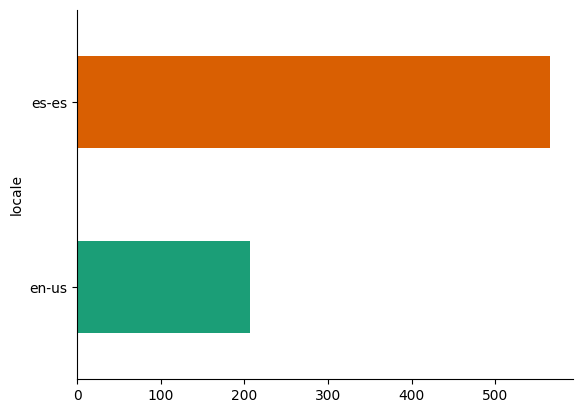

In [ ]:
# @title locale

from matplotlib import pyplot as plt
import seaborn as sns
df_datos.groupby('locale').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
pag = 9
url = 'https://app.ticketmaster.com/discovery/v2/events?apikey=4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs&countryCode=ES&classificationName=music&locale=*&page=' + str(pag)
r = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
print(r.status_code)

# respuesta es un diccionario con 3 claves
respuesta = r.json()

respuesta

links = respuesta['_links']
print(links)

datos = respuesta['_embedded']

pages = respuesta['page']
print(pages)

datos

df = pd.DataFrame(datos['events']) #para constriur el dataframe con los eventos
df

200
{'first': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=0&size=20'}, 'prev': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=8&size=20'}, 'self': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&page=9&locale=*'}, 'next': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=10&size=20'}, 'last': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=38&size=20'}}
{'size': 20, 'totalElements': 767, 'totalPages': 39, 'number': 9}


,name,type,id,test,url,locale,images,sales,dates,classifications,promoter,promoters,priceRanges,_links,_embedded
0,TKM Requests 3,event,Z698xZ2qZaajo,False,https://www.ticketmaster.es/event/tkm-requests...,en-us,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2024-02-02T19:00...,"{'start': {'localDate': '2024-04-02', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '3351', 'name': 'Ticketmaster Pasarela ...","[{'id': '3351', 'name': 'Ticketmaster Pasarela...","[{'type': 'standard including fees', 'currency...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Palau Sant Jordi', 'type..."
1,Hermanos Gutiérrez,event,Z698xZ2qZaauc,False,https://www.ticketmaster.es/event/hermanos-gut...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-12-01T09:00...,"{'start': {'localDate': '2024-04-02', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2729', 'name': 'Live Nation España S.A...","[{'id': '2729', 'name': 'Live Nation España S....","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Paral·lel 62', 'type': '..."
2,Fletcher,event,Z698xZ2qZaaZE,False,https://www.ticketmaster.es/event/fletcher-ent...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-10-17T16:00...,"{'start': {'localDate': '2024-04-03', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2729', 'name': 'Live Nation España S.A...","[{'id': '2729', 'name': 'Live Nation España S....","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Palacio Vistalegre', 'ty..."
3,The Warning – Vip Package,event,Z698xZ2qZaa5v,False,https://www.ticketmaster.es/event/the-warning-...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-11-24T09:00...,"{'start': {'localDate': '2024-04-04', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2729', 'name': 'Live Nation España S.A...","[{'id': '2729', 'name': 'Live Nation España S....","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'La Riviera', 'type': 've..."
4,The Warning,event,Z698xZ2qZaa6h,False,https://www.ticketmaster.es/event/the-warning-...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-11-24T09:00...,"{'start': {'localDate': '2024-04-04', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2729', 'name': 'Live Nation España S.A...","[{'id': '2729', 'name': 'Live Nation España S....","[{'type': 'standard including fees', 'currency...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'La Riviera', 'type': 've..."
5,Pol Granch - Tour 2024,event,Z698xZ2qZaa85,False,https://www.ticketmaster.es/event/pol-granch-t...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-12-05T11:00...,{'access': {'startDateTime': '2023-04-04T21:00...,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2771', 'name': 'Promociones Musicales ...","[{'id': '2771', 'name': 'Promociones Musicales...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Kafe Antzokia', 'type': ..."
6,Fletcher,event,Z698xZ2qZaaZg,False,https://www.ticketmaster.es/event/fletcher-ent...,es-es,"[{'ratio': '16_9', 'url': 'https://s1.ticketm....",{'public': {'startDateTime': '2023-10-17T16:00...,"{'start': {'localDate': '2024-04-04', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2729', 'name': 'Live Nation España S.A...","[{'id': '2729', 'name': 'Live Nation España S....","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'self': {'href': '/discovery/v2/events/Z6

In [ ]:
df.iloc[5,15]['attractions']

IndexError: index 15 is out of bounds for axis 0 with size 15

In [ ]:
path = Path.cwd()   # 16/2/24 -> 39 paginas - 776 filas
print(path)
p = Path(path,"datos.csv")
df_datos.to_csv(p,index=False)
print(p)

In [ ]:
path = Path.cwd()   # 17/2/24 -> 39 paginas - 777 filas
print(path)
p = Path(path,"datos_17_02.csv")
df_datos.to_csv(p,index=False)
print(p)

In [ ]:


# Crea un cliente de la API de Ticketmaster
tm_client = ticketpy.ApiClient('4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs')

# Inicializa listas para almacenar los datos de los eventos
event_data = []

# Busca eventos de música en España en un rango de fechas específico
pages = tm_client.events.find(
    classification_name='Music',  # Filtra por eventos de música
    country_code='ES',  # Filtra por el código de país de España
    start_date_time='2022-02-01T00:00:00Z',  # Fecha de inicio del rango de búsqueda
    end_date_time='2025-02-28T23:59:59Z', # Fecha de finalización del rango de búsqueda
)
counter = 0
# Itera sobre los resultados e imprime la información de cada evento
# Itera sobre los resultados e imprime la información de cada evento
for page in pages:
    for event in page:
        # Accede a la información del lugar del evento
        venue_name = event.venues[0].name if event.venues else None
        city = event.venues[0].city if event.venues and event.venues[0].city else None

        # Verifica si event.utc_datetime es None antes de acceder a sus atributos
        if event.utc_datetime:
            end_day = event.utc_datetime.date()
            end_time = event.utc_datetime.strftime("%H:%M:%S")
        else:
            end_day = None
            end_time = None

        # Crea un diccionario con la información del evento
        event_info = {
            'Nombre del evento': event.name,
            'Fecha de inicio': event.local_start_date,
            'Hora de inicio': event.local_start_time,
            'Estado': event.status,
            'Lugar del evento': venue_name,
            'Fecha de fin': end_day,
            'Hora de fin': end_time,
            'Ciudad del evento': city,
            'Rangos de precio': event.price_ranges[0] if event.price_ranges else {'min': 0, 'max': 0},
        }
        # Agrega el diccionario a la lista de datos del evento
        event_data.append(event_info)

        # Incrementa el contador
        counter += 1

        # Si se han procesado 50 eventos, detén el bucle
        if counter == 50:
            break

# Crear DataFrame a partir de los datos recopilados
df = pd.DataFrame(event_data)

# Mostrar el DataFrame

# filtro = df['Nombre del evento'].str.contains('Emilia')
# len(df[filtro])

# fila = df[df['Nombre del evento'].str.contains('Big Time Rush')]
# fila
df

In [ ]:

# Crea un cliente de la API de Ticketmaster
tm_client = ticketpy.ApiClient('4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs')

# Inicializa listas para almacenar los datos de los eventos
event_data = []
lugares_data = []

# Busca eventos de música en España en un rango de fechas específico
pages = tm_client.events.find(
    classification_name='Music',  # Filtra por eventos de música
    #country_code='ES',  # Filtra por el código de país de España
    start_date_time='2019-02-01T00:00:00Z',  # Fecha de inicio del rango de búsqueda
    end_date_time='2020-02-28T23:59:59Z', # Fecha de finalización del rango de búsqueda
)
counter = 0
# Itera sobre los resultados e imprime la información de cada evento
# Itera sobre los resultados e imprime la información de cada evento
for page in pages:
    for event in page:
        # Accede a la información del lugar del evento
        venue_name = event.venues[0].name if event.venues else None
        city = event.venues[0].city if event.venues and event.venues[0].city else None

        # Verifica si event.utc_datetime es None antes de acceder a sus atributos
        if event.utc_datetime:
            end_day = event.utc_datetime.date()
            end_time = event.utc_datetime.strftime("%H:%M:%S")
        else:
            end_day = None
            end_time = None

        # Crea un diccionario con la información del evento
        event_info = {
            'Nombre del evento': event.name,
            'Fecha de inicio': event.local_start_date,
            'Hora de inicio': event.local_start_time,
            'Estado': event.status,
            'Lugar del evento': venue_name,
            'Fecha de fin': end_day,
            'Hora de fin': end_time,
            'Ciudad del evento': city,
            'Rangos de precio': event.price_ranges[0] if event.price_ranges else {'min': 0, 'max': 0},
            'Lugar y ciudad': str(venue_name) + ', ' + city
        }
        # Agrega el diccionario a la lista de datos del evento
        event_data.append(event_info)
        #df['Lugar_y_ciudad'] = df['Lugar del evento'] + ' - ' + df['Ciudad del evento']

        #df_lugar_ciudad = df['Lugar y ciudad'].copy()

        # Incrementa el contador
        counter += 1

        # Si se han procesado 50 eventos, detén el bucle
        if counter == 50:
            break

# Crear DataFrame a partir de los datos recopilados
df = pd.DataFrame(event_data)

# Mostrar el DataFrame
len(df)
